Dans ce notebook, nous allons implémenter l'algorithme de Deep Qlearning et l'appliquer sur le problème du Cart Pole.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import gym
env = gym.make("CartPole-v1")
print("environnement avec ", env.action_space.n, " actions")
print("l'espace des états est lui codé avec une class", env.observation_space,
      " qui représente un espace continu")
print("les bornes inférieures des intervalles sont: ", env.observation_space.low)
print("les bornes supérieures des intervalles sont: ",env.observation_space.high)
env.reset()
nbIt=0
done=False
while not done:
  observation, reward, done, info = env.step(np.random.randint(2))
  nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env.close()

environnement avec  2  actions
l'espace des états est lui codé avec une class Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)  qui représente un espace continu
les bornes inférieures des intervalles sont:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
les bornes supérieures des intervalles sont:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 50 itérations


In [ ]:
from torch.nn import parameter
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear,Sequential,ReLU,MSELoss,LeakyReLU

class DeepQ_Learning():    
    def __init__(self, dim_etats, dim_actions, dim_couche_cachee=64, alpha=0.01):
            self.modele = Sequential(
                            Linear(dim_etats, dim_couche_cachee),
                            LeakyReLU(),
                            Linear(dim_couche_cachee, dim_couche_cachee*2),
                            LeakyReLU(),
                            Linear(dim_couche_cachee*2, dim_actions)
                    )
            self.fonction_cout = MSELoss()            
            self.algo_optimisation = Adam(self.modele.parameters(), alpha)   

    def predire_q(self, etat):
            """ Prédiction des valeurs de Q pour toutes les actions """
            with torch.no_grad():
                return self.modele(torch.Tensor(etat))
    def entrainement(self, etat, y):
            """Entrainement du réseau : mise à jour des poids (back propagation)"""
            pred = self.modele(torch.Tensor(etat))
            fonction_cout = self.fonction_cout(pred, Variable(torch.Tensor(y)))

            self.algo_optimisation.zero_grad()
            fonction_cout.backward()
            self.algo_optimisation.step()

In [ ]:
def epsilon_greedy(q,epsilon):
  exploration = np.random.binomial(1,epsilon)

  if exploration:
        action = env.action_space.sample()
  else:
        action = torch.argmax(q).item()
  return action

def lancement_deepQ_learning(env, modele, episodes, gamma=0.9, epsilon=0.5, eps_ratio=1.01):
    """Deep Q Learning algorithm using the DQN. """
    tailles_episodes = []

    for episode in tqdm(range(episodes)):      

        #Choix d'un espilon décroissant (minimum à 15%)
        epsilon = max(0.01,epsilon/eps_ratio)
        
        s = env.reset()
        gameover = False
        taille_episode = 0        
        while not gameover:

            # Selection de l'action avec epsilon greedy
            q = modele.predire_q(s)
            a = epsilon_greedy(q,epsilon)
            
            s_p, r, gameover, infos = env.step(a)
            
            
            taille_episode += r
            q = modele.predire_q(s).tolist()
             
            if gameover:                
                q[a] = r
                # Mise à jour des poids du réseau
                modele.entrainement(s, q)
                break 

            q_p = modele.predire_q(s_p)
            q[a] = r + gamma * torch.max(q_p).item()
            # Mise à jour des poids du réseau
            modele.entrainement(s, q)
            s = s_p
        
        tailles_episodes.append(taille_episode)
    return tailles_episodes,modele

In [ ]:
dim_état = 4
dim_action = 2
modele = DeepQ_Learning(4,2)
env = gym.make("CartPole-v1")

tailles_episodes_deep_q_learning,modele_entraine = lancement_deepQ_learning(env,modele,200)

100%|██████████| 200/200 [00:11<00:00, 16.81it/s]


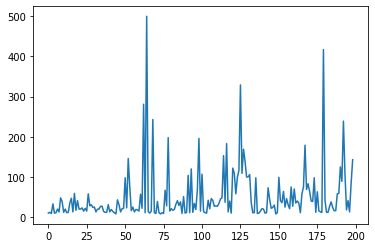

In [ ]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res
  
plt.plot(runningAvg(tailles_episodes_deep_q_learning, windowSize=1))

In [ ]:
def Deep_Q_learning_exploitation(env, modele, episodes, gamma=0.9):
    tailles_episodes = []

    for episode in tqdm(range(episodes)):       
        
        s = env.reset()
        gameover = False
        taille_episode = 0
        
        while not gameover:
            q = modele.predire_q(s)
            a = torch.argmax(q).item()
            
            s, r, gameover, infos = env.step(a)
            
            taille_episode += 1
             
            if gameover:                
                break          

        tailles_episodes.append(taille_episode)
    return tailles_episodes

Nous allons exploiter le modèle entraîné

In [ ]:
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,modele_entraine,1000)

100%|██████████| 1000/1000 [00:06<00:00, 156.86it/s]


In [ ]:
np.mean(tailles_episodes_deep_q_learning)


51.571

On remarque que le modèle n'arrive pour le moment qu'à maintenir la barre en équilibre que pendant 51 épisodes en moyenne.
Cela est dû au fait que le réseau de neurone ne conserve pas en mémoire les expériences passées de l'agent. Nous allons voir dans la suite comment améliorer notre modèle avec la variante experience replay dans la partie suivante

### Implémentation de Deep Q learning avec experience replay

Nous allons ajouter une mémoire à notre modèle pour pouvoir stocker les transitions $(s_t,a_t,r_{t+1},s_{t+1})$ en mémoire.

Cela permet d'améliorer la stabilité du réseau et de s'assurer que les expériences passées de l'agent ne soient pas oubliées pendant l'entraînement.

On va tirer aléatoirement des batchs d'expériences depuis la mémoire pour entrainer le réseau de neurones.



In [ ]:
from torch.nn import parameter
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear,Sequential,ReLU,MSELoss,LeakyReLU

class DeepQ_Learning_avec_memoire(DeepQ_Learning):  

  """
  Il s'agit d'une extension de la classe DeepQ_Learning avec
  la notion d'experience replay (échantillonnage dans les expériences passées)
  """
  def experience_replay(self, memoire, size, gamma=0.9):
      #On attend que la mémoire soit suffisamment grande avant de 
      #faire l'échantillonnage des expériences passées
        if len(memoire) >= size:
            etats = []
            y = []

            #Echantillonage d'un batch d'expériences passées 
            #depuis la mémoire
            batch_experiences = random.sample(memoire, size)
            
            for s, a, s_p, r, gameover in batch_experiences:
                etats.append(s)                
                q = self.predire_q(s).tolist()
                if gameover:
                    q[a] = r
                else:
                    q_p = self.predire_q(s_p)
                    q[a] = r + gamma * torch.max(q_p).item()
                y.append(q)
            self.entrainement(etats, y)


def lancement_deepQ_learning_avec_memoire(env, modele, episodes, gamma=0.9, epsilon=0.4, eps_decay=0.99,replay_size=30):
    tailles_episodes = []
    memoire = []
    for episode in tqdm(range(episodes)):               
        # Reset state
        s = env.reset()
        gameover = False
        taille_episode = 0
        epsilon = max(epsilon * eps_decay, 0.2)
        
        while not gameover:

            # Selection de l'action avec epsilon greedy
            q = modele.predire_q(s)
            a = epsilon_greedy(q,epsilon)
            
            s_p, r, gameover, _ = env.step(a)
            
            taille_episode += r
            #Stockage de la transition dans la mémoire
            memoire.append((s, a, s_p, r, gameover))
            
            q = modele.predire_q(s).tolist()
             
            if gameover:                
                break
              
            modele.experience_replay(memoire, replay_size, gamma)
            s = s_p
                
        tailles_episodes.append(taille_episode)
    return tailles_episodes,modele

In [ ]:
modele = DeepQ_Learning_avec_memoire(4,2)
env = gym.make("CartPole-v1")

tailles_episodes_deep_q_learning,modele_entraine = lancement_deepQ_learning_avec_memoire(env,modele,150)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Voici l'évolution de la taille de l'épisode pendant l'entrainement du modèle Deep Q learning avec experience replay :

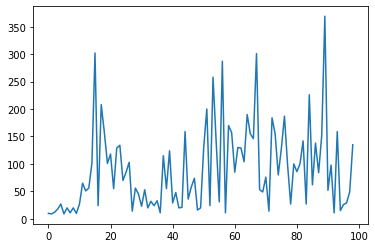

In [ ]:
plt.plot(runningAvg(tailles_episodes_deep_q_learning, windowSize=1))


In [ ]:
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,modele_entraine,2000)
np.mean(tailles_episodes_deep_q_learning)

221.645

Avec ce premier entraînement du modèle Deep Q learning avec experience replay, on arrive à tenir en équibre en moyenne pendant 221 itérations. On remarque que le modèle avec mémoire obtient de meilleures performances que le modèle sans mémoire.

J'ai ensuite testé avec un epsilon dégressif (multiplication par 0.99 à chaque itération) : 


In [ ]:
modele = DeepQ_Learning_avec_memoire(4,2)
tailles_episodes_deep_q_learning,modele_entraine = lancement_deepQ_learning_avec_memoire(env,modele,150)


100%|██████████| 150/150 [01:24<00:00,  1.77it/s]


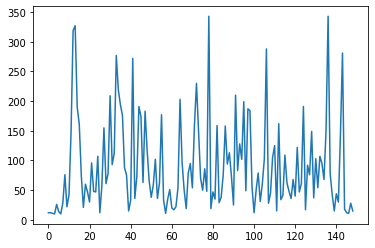

In [ ]:
plt.plot(runningAvg(tailles_episodes_deep_q_learning, windowSize=1))

In [ ]:
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,modele_entraine,1000)
print("\nTaille moyenne d'un épisode sur 1000 épisodes :", np.mean(tailles_episodes_deep_q_learning))

100%|██████████| 1000/1000 [00:14<00:00, 68.55it/s]


Taille moyenne d'un épisode sur 1000 épisodes : 433.51


Après plusieurs essais, j'ai réussi à converger vers un modèle qui réussie à atteindre **les 500 itérations maximales pour chaque épisode** sur 1000 épisodes :

Le modèle a été enregistré dans le fichier modele_deepQN_CartPole.pkl fourni avec le notebook. Il s'agit d'un objet de la classe DeepQ_Learning_avec_memoire. Cet objet peut être chargé avec le module pickle avec la cellule ci_dessous :

In [ ]:
import pickle
from torch.nn import parameter
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear,Sequential,ReLU,MSELoss,LeakyReLU
import gym
from  tqdm import tqdm

class DeepQ_Learning_avec_memoire():    
    def __init__(self, dim_etats, dim_actions, dim_couche_cachee=64, alpha=0.05):
            self.modele = Sequential(

                            Linear(dim_etats, dim_couche_cachee),
                            LeakyReLU(),
                            Linear(dim_couche_cachee, dim_couche_cachee*2),
                            LeakyReLU(),
                            Linear(dim_couche_cachee*2, dim_actions)
                    )
            self.fonction_cout = MSELoss()            
            self.algo_optimisation = Adam(self.modele.parameters(), alpha)   

    def predire_q(self, s):
            """ Prédiction des valeurs de Q pour toutes les actions """
            with torch.no_grad():
                return self.modele(torch.Tensor(s))
    def entrainement(self, s, y):
            """Entrainement du réseau : mise à jour des poids (back propagation)"""
            pred = self.modele(torch.Tensor(s))
            fonction_cout = self.fonction_cout(pred, Variable(torch.Tensor(y)))

            self.algo_optimisation.zero_grad()
            fonction_cout.backward()
            self.algo_optimisation.step()

    def experience_replay(self, memoire, size, gamma=0.9):
      #On attend que la mémoire soit suffisamment grande avant de 
      #faire l'échantillonnage des expériences passées
        if len(memoire) >= size:
            etats = []
            y = []

            #Echantillonage d'un batch d'expériences passées 
            #depuis la mémoire
            batch_experiences = random.sample(memoire, size)
            
            for s, a, s_p, r, gameover in batch_experiences:
                etats.append(s)                
                q = self.predire_q(s).tolist()
                if gameover:
                    q[a] = r
                else:
                    q_p = self.predire_q(s_p)
                    q[a] = r + gamma * torch.max(q_p).item()
                y.append(q)
            self.entrainement(etats, y)

def Deep_Q_learning_exploitation(env, modele, episodes, gamma=0.9):
    tailles_episodes = []

    for episode in tqdm(range(episodes)):       
        
        s = env.reset()
        gameover = False
        taille_episode = 0
        
        while not gameover:
            q = modele.predire_q(s)
            a = torch.argmax(q).item()
            
            s, r, gameover, infos = env.step(a)
            
            taille_episode += 1
             
            if gameover:                
                break          

        tailles_episodes.append(taille_episode)
    return tailles_episodes

with open("modele_deepQN_CartPole.pkl", "rb") as f:
  model = pickle.load(f)

On peut ensuite exploiter le modèle sur 1000 épisodes :

In [ ]:
env = gym.make("CartPole-v1")

#Exploitation du modèle sur 1000 épisodes
tailles_episodes_deep_q_learning = Deep_Q_learning_exploitation(env,model,1000)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tailles_episodes_deep_q_learning)
